In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import re
import string
import sys
import nltk
from nltk import pos_tag_sents
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import spacy


# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Initializing
---

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
info = pd.DataFrame(index = train.columns,columns = ['unique','null','% null'])
unique = train.apply(pd.Series.nunique)
nulls = train.isnull().sum()
info['unique'] = unique
info['null']= nulls
info['% null'] = round((nulls/len(train))*100,2)
info

,unique,null,% null
id,7613,0,0.00
keyword,221,61,0.80
location,3341,2533,33.27
text,7503,0,0.00
target,2,0,0.00


In [5]:
df = train.copy(deep= True)
df['keyword'].fillna('no_keyword', inplace=True)
df['location'].fillna('no_location', inplace=True)

## Fake Tweets vs Real tweets 

Text(0.5, 1.0, 'Total Counts of Fake vs Real tweets')

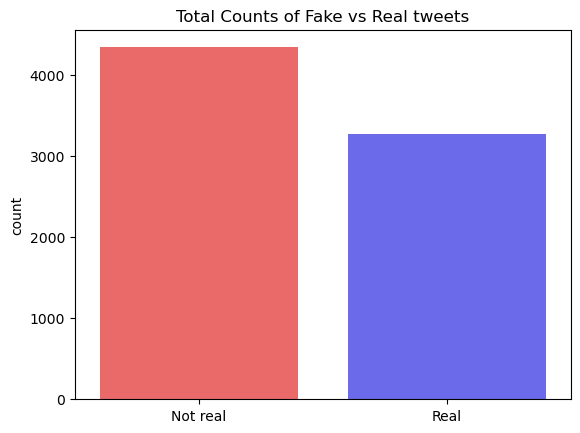

In [6]:
sns.countplot(x = 'target', data = df, palette = 'seismic_r')
labels = ['Not real', 'Real']
plt.gca().set_xticklabels(labels)
plt.gca().set_xlabel('')
plt.gca().set_title('Total Counts of Fake vs Real tweets')

Text(0.5, 1.0, 'Number of tweets per keyword of Real and Fake Tweets')

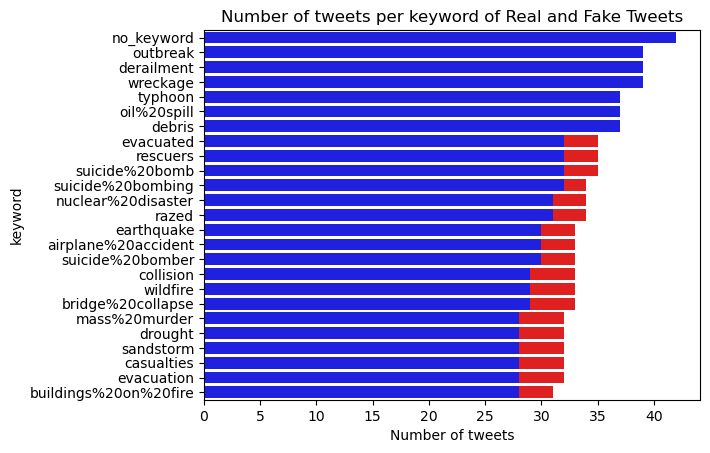

In [7]:
keyword_fake = df[df['target'] == 0].groupby('keyword').count().drop(columns=['target', 'id']).sort_values(by='text', ascending=False)[:25]
keyword_real = df[df['target'] == 1].groupby('keyword').count().drop(columns=['target', 'id']).sort_values(by='text', ascending=False)[:25]

sns.barplot(data=keyword_fake,y=keyword_real.index, x = 'text',color='red',) #number of fake tweets
sns.barplot(data=keyword_real,y=keyword_real.index, x = 'text',color='blue')#number of real tweets
plt.gca().set_xlabel('Number of tweets')
plt.gca().set_title('Number of tweets per keyword of Real and Fake Tweets')

#keyword_data = df.groupby('keyword')['target'].value_counts().unstack(fill_value=0).sort_values(by=1, ascending=False)[:25]
#keyword_data
#keyword_data.plot(kind='barh')

# **Cleaning**
---

In [8]:
df['text'] = df['text'].astype("string")
df.drop_duplicates(subset = 'text',inplace = True) #should we drop duplicates based on text alone, maybe if keyword, location and text are all the same only?
df.sample(10, random_state = 42)

,id,keyword,location,text,target
2330,3351,demolished,"Paterson, New Jersey",Three Homes Demolished in Unrecognized Arab Vi...,1
3391,4854,evacuation,no_location,Reid Lake fire prompts campground evacuation o...,1
3363,4814,evacuation,no_location,FAAN orders evacuation of abandoned aircraft a...,0
4632,6583,injury,Baltimore,Ngata on injury list at start of practice for ...,0
7588,10842,no_keyword,no_location,BREAKING: #ISIS claims responsibility for mosq...,1
4862,6921,mass%20murderer,"Eww, I'm not Paul Elam",Reminder: Mass murderer and white supremacist ...,1
1561,2255,cliff%20fall,no_location,@D33munni @JeanNamibian noooooooo ... *proceed...,0
4061,5771,forest%20fires,Texas,' no pharrell only YOU can prevent forest fir...,0
1721,2483,collided,Pakistan,SSP East says a car AEG 061 driven by a young ...,1
3138,4509,emergency,USA,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,0


## Removing punctiation
* remove rewtweets/hastags/urls/

In [9]:
#Creating new dataframe
tweets = df[['target', 'text']].copy()
tweets['clean'] = df.text
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
remove_usernames = lambda x: re.sub('@[^\s]+',' ',x)
remove_urls = lambda x: re.sub(r'http\S+', '', x)
remove_punctuation = lambda x: re.sub('[^a-zA-Z\s]+', ' ', x)
remove_hashtags = lambda x: re.sub('\B#\w*[a-zA-Z]+\w*', ' ', x)
lowercase = lambda x: x.lower()

tweets['clean'] = tweets.text.map(remove_rt).map(remove_usernames).map(remove_urls).map(remove_punctuation).map(remove_hashtags).map(lowercase)
tweets.sample(10, random_state = 42)
#tweets.loc[978]

,target,text,clean
2330,1,Three Homes Demolished in Unrecognized Arab Vi...,three homes demolished in unrecognized arab vi...
3391,1,Reid Lake fire prompts campground evacuation o...,reid lake fire prompts campground evacuation o...
3363,0,FAAN orders evacuation of abandoned aircraft a...,faan orders evacuation of abandoned aircraft a...
4632,0,Ngata on injury list at start of practice for ...,ngata on injury list at start of practice for ...
7588,1,BREAKING: #ISIS claims responsibility for mosq...,breaking isis claims responsibility for mosq...
4862,1,Reminder: Mass murderer and white supremacist ...,reminder mass murderer and white supremacist ...
1561,0,@D33munni @JeanNamibian noooooooo ... *proceed...,noooooooo proceeds to fall off a cliff
4061,0,' no pharrell only YOU can prevent forest fir...,no pharrell only you can prevent forest fir...
1721,1,SSP East says a car AEG 061 driven by a young ...,ssp east says a car aeg driven by a young ma...
3138,0,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,deals temporary fake tooth teeth replacem...


## NLTK Cleaning
* Tokenization
* Stop word removal
* tagging


In [10]:
tweets['tokenized'] = tweets.clean.apply(lambda x: word_tokenize(x.lower()))
stopword = nltk.corpus.stopwords.words('english')
def remove_stop(text):
    text = [word for word in text if word not in stopword]
    return text
tweets['sw_removed']= tweets.tokenized.apply(lambda x: remove_stop(x))
tweets.sample(10, random_state =42)

,target,text,clean,tokenized,sw_removed
2330,1,Three Homes Demolished in Unrecognized Arab Vi...,three homes demolished in unrecognized arab vi...,"[three, homes, demolished, in, unrecognized, a...","[three, homes, demolished, unrecognized, arab,..."
3391,1,Reid Lake fire prompts campground evacuation o...,reid lake fire prompts campground evacuation o...,"[reid, lake, fire, prompts, campground, evacua...","[reid, lake, fire, prompts, campground, evacua..."
3363,0,FAAN orders evacuation of abandoned aircraft a...,faan orders evacuation of abandoned aircraft a...,"[faan, orders, evacuation, of, abandoned, airc...","[faan, orders, evacuation, abandoned, aircraft..."
4632,0,Ngata on injury list at start of practice for ...,ngata on injury list at start of practice for ...,"[ngata, on, injury, list, at, start, of, pract...","[ngata, injury, list, start, practice, lions]"
7588,1,BREAKING: #ISIS claims responsibility for mosq...,breaking isis claims responsibility for mosq...,"[breaking, isis, claims, responsibility, for, ...","[breaking, isis, claims, responsibility, mosqu..."
4862,1,Reminder: Mass murderer and white supremacist ...,reminder mass murderer and white supremacist ...,"[reminder, mass, murderer, and, white, suprema...","[reminder, mass, murderer, white, supremacist,..."
1561,0,@D33munni @JeanNamibian noooooooo ... *proceed...,noooooooo proceeds to fall off a cliff,"[noooooooo, proceeds, to, fall, off, a, cliff]","[noooooooo, proceeds, fall, cliff]"
4061,0,' no pharrell only YOU can prevent forest fir...,no pharrell only you can prevent forest fir...,"[no, pharrell, only, you, can, prevent, forest...","[pharrell, prevent, forest, fires]"
1721,1,SSP East says a car AEG 061 driven by a young ...,ssp east says a car aeg driven by a young ma...,"[ssp, east, says, a, car, aeg, driven, by, a, ...","[ssp, east, says, car, aeg, driven, young, man..."
3138,0,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,deals temporary fake tooth teeth replacem...,"[deals, temporary, fake, tooth, teeth, replace...","[deals, temporary, fake, tooth, teeth, replace..."


In [11]:
#nltk.download('averaged_perceptron_tagger')

def tag_words(words):
    return pos_tag_sents([words])[0]

tweets['tagged'] = tweets['sw_removed'].apply(tag_words)

tweets.sample(10, random_state =42)

,target,text,clean,tokenized,sw_removed,tagged
2330,1,Three Homes Demolished in Unrecognized Arab Vi...,three homes demolished in unrecognized arab vi...,"[three, homes, demolished, in, unrecognized, a...","[three, homes, demolished, unrecognized, arab,...","[(three, CD), (homes, NNS), (demolished, VBD),..."
3391,1,Reid Lake fire prompts campground evacuation o...,reid lake fire prompts campground evacuation o...,"[reid, lake, fire, prompts, campground, evacua...","[reid, lake, fire, prompts, campground, evacua...","[(reid, NNS), (lake, VBP), (fire, NN), (prompt..."
3363,0,FAAN orders evacuation of abandoned aircraft a...,faan orders evacuation of abandoned aircraft a...,"[faan, orders, evacuation, of, abandoned, airc...","[faan, orders, evacuation, abandoned, aircraft...","[(faan, JJ), (orders, NNS), (evacuation, NN), ..."
4632,0,Ngata on injury list at start of practice for ...,ngata on injury list at start of practice for ...,"[ngata, on, injury, list, at, start, of, pract...","[ngata, injury, list, start, practice, lions]","[(ngata, JJ), (injury, NN), (list, NN), (start..."
7588,1,BREAKING: #ISIS claims responsibility for mosq...,breaking isis claims responsibility for mosq...,"[breaking, isis, claims, responsibility, for, ...","[breaking, isis, claims, responsibility, mosqu...","[(breaking, VBG), (isis, NN), (claims, NNS), (..."
4862,1,Reminder: Mass murderer and white supremacist ...,reminder mass murderer and white supremacist ...,"[reminder, mass, murderer, and, white, suprema...","[reminder, mass, murderer, white, supremacist,...","[(reminder, NN), (mass, NN), (murderer, NN), (..."
1561,0,@D33munni @JeanNamibian noooooooo ... *proceed...,noooooooo proceeds to fall off a cliff,"[noooooooo, proceeds, to, fall, off, a, cliff]","[noooooooo, proceeds, fall, cliff]","[(noooooooo, JJ), (proceeds, NNS), (fall, VBP)..."
4061,0,' no pharrell only YOU can prevent forest fir...,no pharrell only you can prevent forest fir...,"[no, pharrell, only, you, can, prevent, forest...","[pharrell, prevent, forest, fires]","[(pharrell, NN), (prevent, NN), (forest, NN), ..."
1721,1,SSP East says a car AEG 061 driven by a young ...,ssp east says a car aeg driven by a young ma...,"[ssp, east, says, a, car, aeg, driven, by, a, ...","[ssp, east, says, car, aeg, driven, young, man...","[(ssp, NN), (east, NN), (says, VBZ), (car, NN)..."
3138,0,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,deals temporary fake tooth teeth replacem...,"[deals, temporary, fake, tooth, teeth, replace...","[deals, temporary, fake, tooth, teeth, replace...","[(deals, NNS), (temporary, JJ), (fake, VBP), (..."


In [12]:
fakeTargets = tweets['target'] == 0
token_series_f = tweets[fakeTargets]['sw_removed'].drop_duplicates().sum()
fd_f = nltk.FreqDist(token_series_f)
common_fake = fd_f.most_common(10)

realTargets = tweets['target'] == 1
token_series_r = tweets[fakeTargets]['sw_removed'].drop_duplicates().sum()
fd_r = nltk.FreqDist(token_series_r)
common_real = fd_r.most_common(10)

if common_fake == common_real:
    print("Both have the same most common words:", common_real)
else:
    print("Most Common Fake: ", common_fake,"Most Common Real:",common_real)
    

Both have the same most common words: [('like', 247), ('amp', 189), ('get', 162), ('new', 134), ('one', 128), ('body', 104), ('would', 100), ('got', 93), ('people', 89), ('via', 88)]


# Sentiment Analysis
---
- Using NLTK
-Start using BERT?

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
tweets['sentiment'] = tweets['clean'].apply(lambda x: sia.polarity_scores(x))
tweets['type'] = tweets['sentiment'].apply(lambda x: max(x, key=x.get))
sent_dict = {'neg': 'negative', 'pos': 'positive', 'neu': 'neutral'}
tweets['max_type'] = tweets['type'].replace(sent_dict)
tweets['max_score'] = tweets['sentiment'].apply(lambda x: x[max(x, key=x.get)])
tweets[['target','clean','sentiment','max_type','max_score']].sample(10, random_state = 42)

,target,clean,sentiment,max_type,max_score
2330,1,three homes demolished in unrecognized arab vi...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
3391,1,reid lake fire prompts campground evacuation o...,"{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...",neutral,0.714
3363,0,faan orders evacuation of abandoned aircraft a...,"{'neg': 0.273, 'neu': 0.727, 'pos': 0.0, 'comp...",neutral,0.727
4632,0,ngata on injury list at start of practice for ...,"{'neg': 0.237, 'neu': 0.763, 'pos': 0.0, 'comp...",neutral,0.763
7588,1,breaking isis claims responsibility for mosq...,"{'neg': 0.432, 'neu': 0.568, 'pos': 0.0, 'comp...",neutral,0.568
4862,1,reminder mass murderer and white supremacist ...,"{'neg': 0.356, 'neu': 0.567, 'pos': 0.077, 'co...",neutral,0.567
1561,0,noooooooo proceeds to fall off a cliff,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
4061,0,no pharrell only you can prevent forest fir...,"{'neg': 0.237, 'neu': 0.645, 'pos': 0.118, 'co...",neutral,0.645
1721,1,ssp east says a car aeg driven by a young ma...,"{'neg': 0.094, 'neu': 0.906, 'pos': 0.0, 'comp...",neutral,0.906
3138,0,deals temporary fake tooth teeth replacem...,"{'neg': 0.318, 'neu': 0.503, 'pos': 0.179, 'co...",neutral,0.503



# Feature Extraction
---

# Citation
---
Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.